In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import kr_helper_funcs as kr
from sklearn.preprocessing import MinMaxScaler
import kr_helper_funcs as kr
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from lime import lime_tabular
import shap
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
name = 'without_postcode'
fileName = "{}/lending-club-values.csv".format(name)
model = tf.keras.models.load_model('{}/lending-club.h5'.format(name), custom_objects={"f1": kr.f1})
X_train_unscaled = np.load("{}/X_train_unscaled.npy".format(name))
X_test_unscaled = np.load("{}/X_test_unscaled.npy".format(name))
y_train = np.load("{}/y_test.npy".format(name))
y_test = np.load("{}/y_test.npy".format(name))
df = pd.read_csv('{}/lending-club-df.csv'.format(name))
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

prev_scaled_row = None
cached_map_values = None
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_unscaled)
X_test = scaler.transform(X_test_unscaled)

res = pd.read_csv(fileName)

In [3]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'earliest_cr_year'],
      dtype='object')

In [4]:
df.corr()["loan_amnt"].sort_values(ascending=False)

loan_amnt                     1.000000
installment                   0.953872
term                          0.393731
annual_inc                    0.337364
revol_bal                     0.328515
verification_status           0.300254
mort_acc                      0.223992
total_acc                     0.223695
open_acc                      0.198347
sub_grade                     0.181900
home_ownership                0.174550
int_rate                      0.168599
purpose_debt_consolidation    0.109815
revol_util                    0.099581
purpose_credit_card           0.022500
application_type              0.022359
purpose_small_business        0.018346
dti                           0.016338
purpose_house                 0.011454
purpose_home_improvement      0.000067
purpose_renewable_energy     -0.016476
purpose_educational          -0.021634
purpose_wedding              -0.031414
purpose_major_purchase       -0.057466
loan_repaid                  -0.059731
purpose_moving           

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0.6410976777502206, 0.6346590136021618, 0.633096715769787, 0.6313505492291828, 0.630158160221457, 0.6285147972533738, 0.6275706819721839, 0.6277390108578307, 0.6266475377846701, 0.6267189657526958, 0.6257892380010905, 0.6254307111219953, 0.6250451243985092]


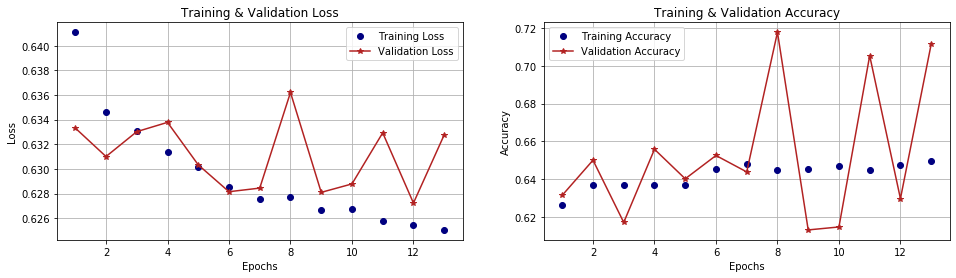

In [5]:
history = pd.read_csv('{}/lending-club-history.csv'.format(name))
history_dict = history.to_dict('list')
kr.show_plots(history_dict)

In [6]:
predictions = model.predict_classes(X_test)
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.35      0.52      0.42     15658
           1       0.87      0.77      0.81     63386

    accuracy                           0.72     79044
   macro avg       0.61      0.64      0.62     79044
weighted avg       0.76      0.72      0.74     79044



[[ 8108  7550]
 [14748 48638]]


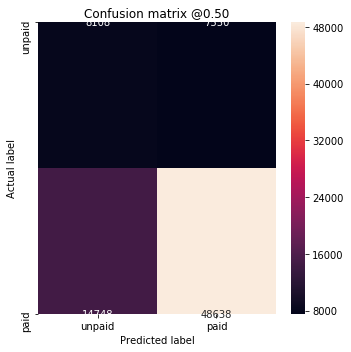

In [7]:
kr.plot_cm(y_test, predictions, ["unpaid", "paid"])

(33, 0)

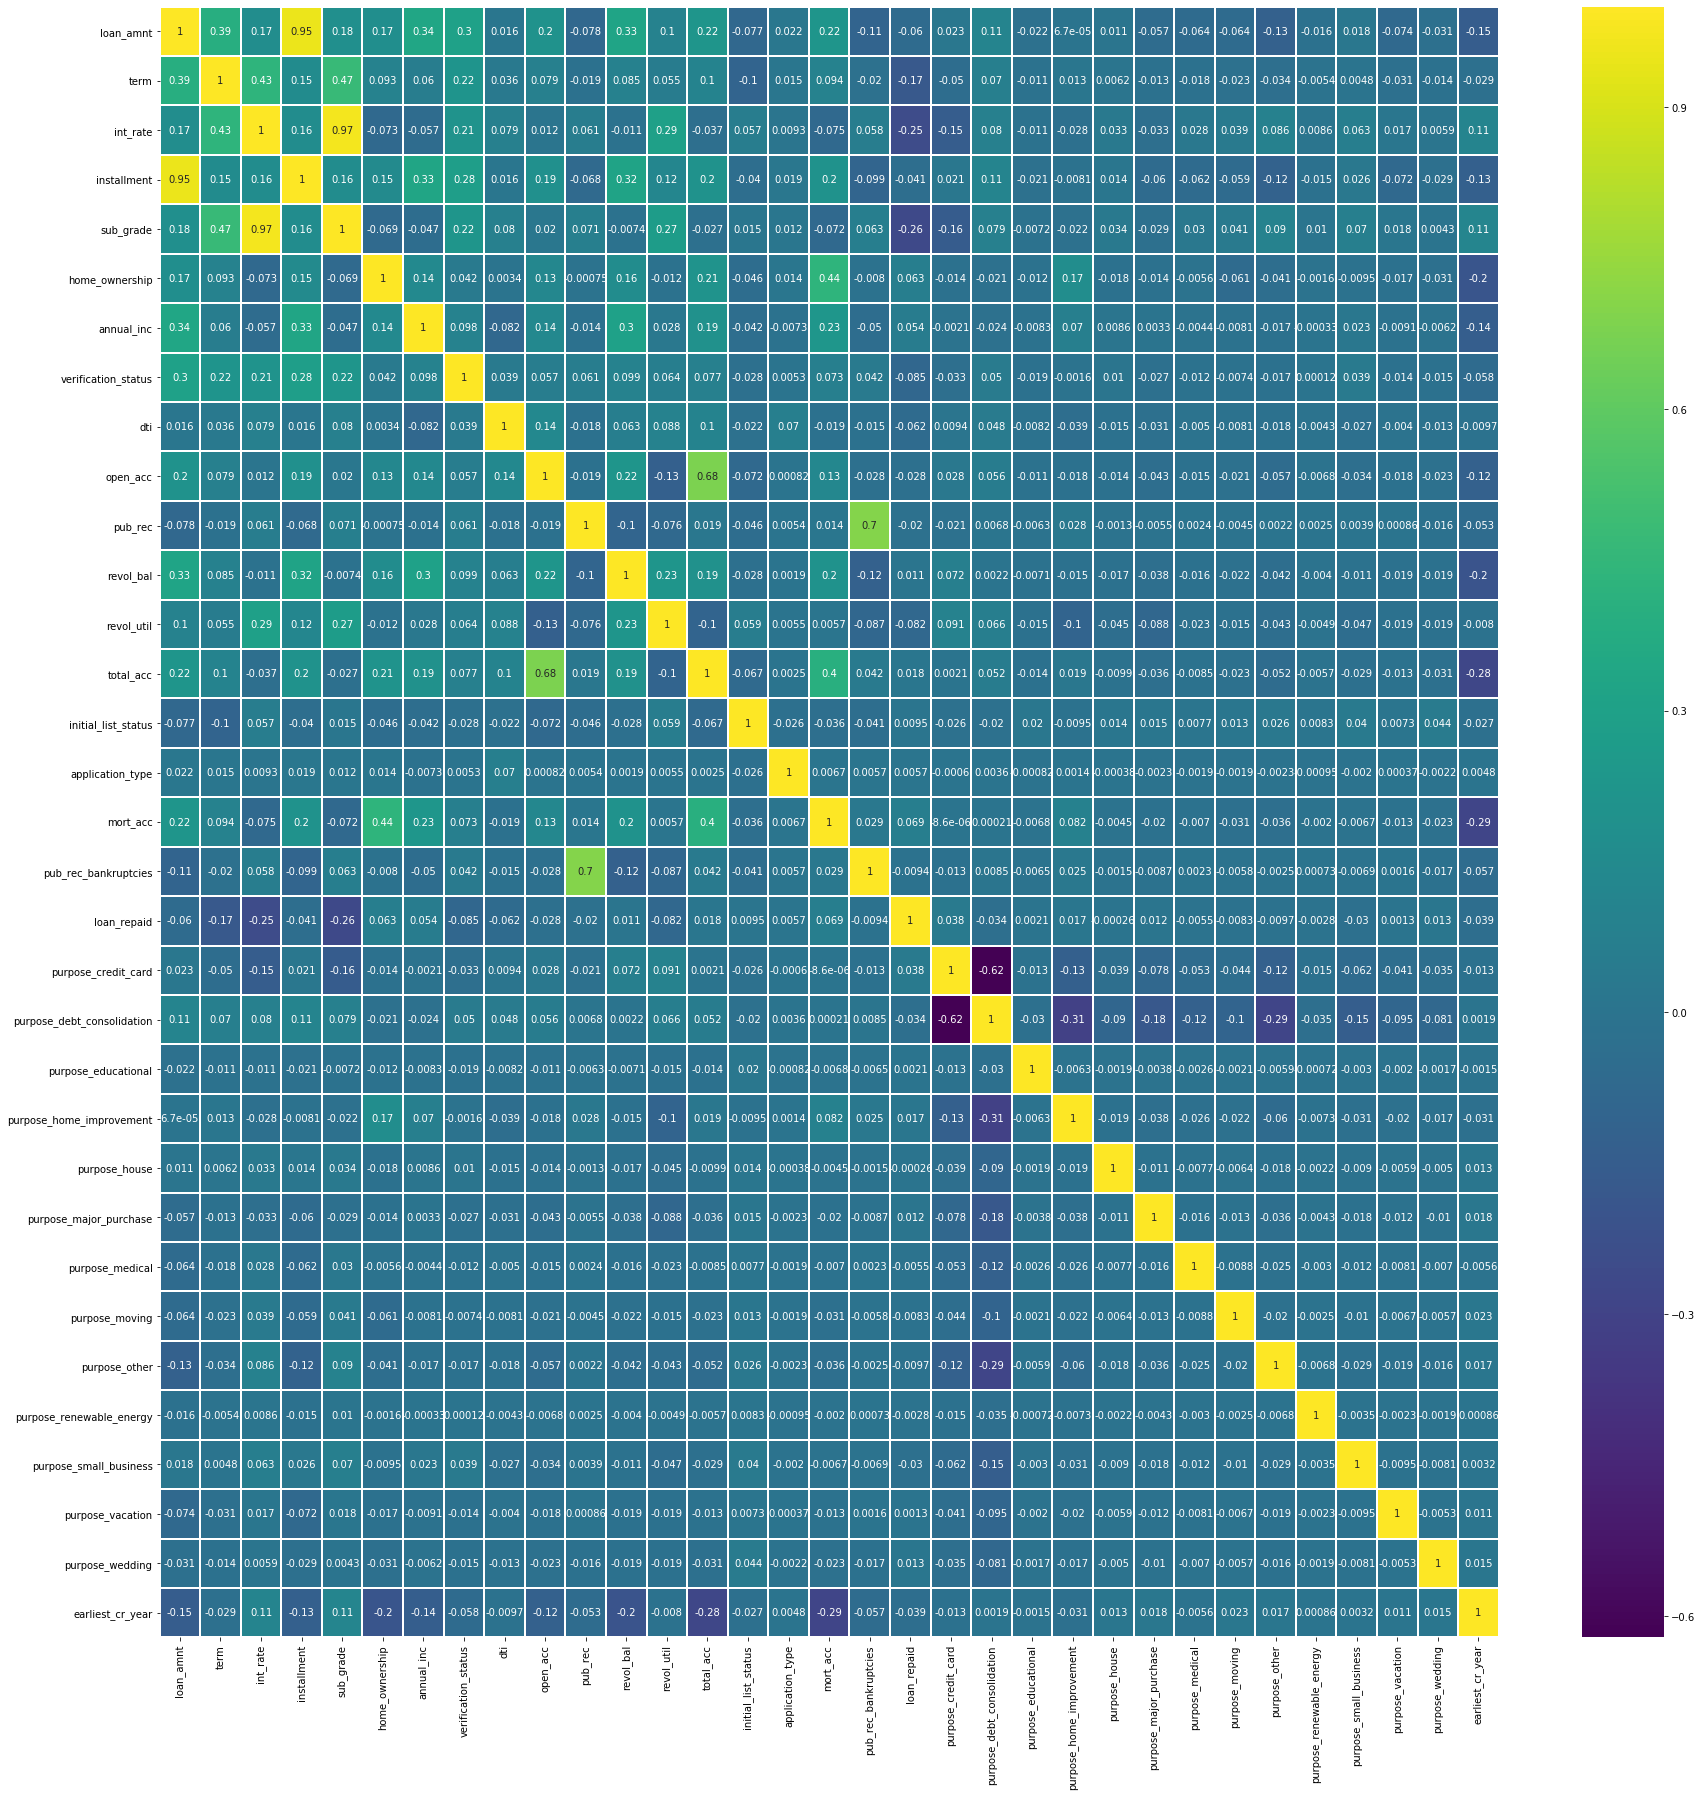

In [8]:
plt.figure(figsize=(30,30))
sns.heatmap(df.corr(),annot=True,cmap='viridis', linewidth=1)
plt.ylim(33, 0)


              precision    recall  f1-score   support

           0       0.35      0.52      0.42     15658
           1       0.87      0.77      0.81     63386

    accuracy                           0.72     79044
   macro avg       0.61      0.64      0.62     79044
weighted avg       0.76      0.72      0.74     79044



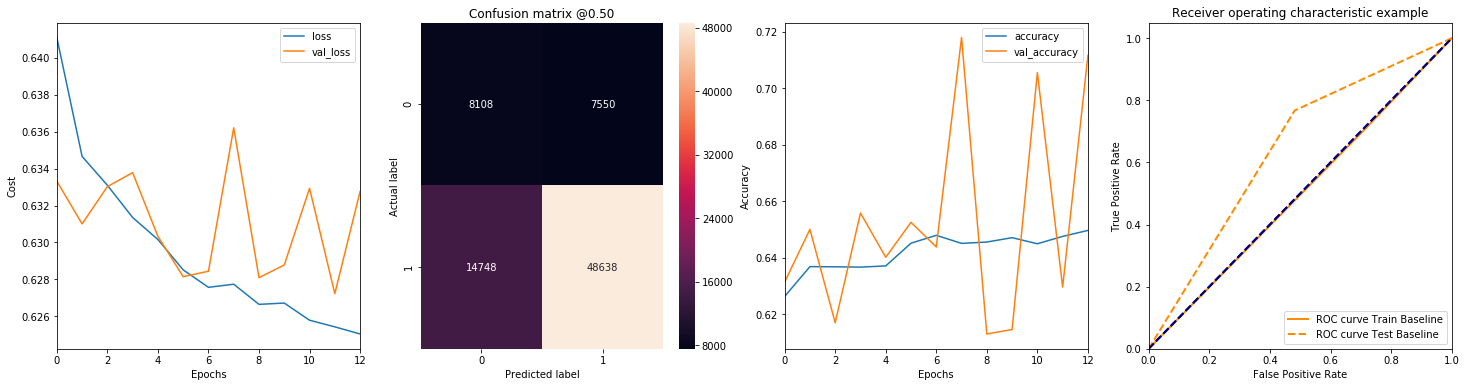

In [9]:
def plot_roc(name, labels, predictions, ax, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)
    lw = 2
    plt.plot(fp, tp, color='darkorange',
             lw=lw, label='ROC curve '+ name, **kwargs)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    
def plot_model_results(model):
    fig, (f1, f2, f3, f4) =plt.subplots(1,4, figsize=(25,6))
    predictions = model.predict_classes(X_test)
    report = classification_report(y_test,predictions)
    print(report)
    report_json = classification_report(y_test,predictions, output_dict=True)
#     save_report_to_latex(model_name, report_json)
    
    
    losses = pd.DataFrame(history)
    fig1 = losses[['loss','val_loss']].plot(ax=f1) 
    fig1.set_ylabel('Cost')
    fig1.set_xlabel('Epochs')
    
    cm = confusion_matrix(y_test,predictions > 0.5)
    fig2= sns.heatmap(cm, annot=True, fmt="d", ax=f2)
    fig2.set_title('Confusion matrix @{:.2f}'.format(0.5))
    fig2.set_ylabel('Actual label')
    fig2.set_xlabel('Predicted label')
    fig2.set_ylim(2, 0)

    fig3 = plot_roc("Train Baseline",y_train, model.predict_classes(X_train[:len(X_test)]) , ax=f4)
    fig3 = plot_roc("Test Baseline", y_test, model.predict_classes(X_test), ax=f4, linestyle='--')
    
    fig4 = losses[['accuracy','val_accuracy']].plot(ax=f3) 
    fig4.set_ylabel('Accuracy')
    fig4.set_xlabel('Epochs')
#     save('/building_ann/' + model_name + '.png')
    plt.show()
plot_model_results(model)

In [10]:
len(X_test)

79044

In [11]:
res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random')].head()


,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,reverse_order,...,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
1848,0.512614,0.512614,5.960464e-08,1,False,0,auto,random,0.834808,False,...,21,4,29,23,3,7,11,13.0,0.0,22.0
1849,0.512614,0.512614,5.960464e-08,1,False,0,auto,random,0.826920,True,...,21,4,29,23,3,7,11,13.0,0.0,22.0
1850,0.512614,0.510869,1.744509e-03,1,False,1,auto,random,0.825718,False,...,21,4,29,23,3,7,11,13.0,0.0,22.0
1851,0.512614,0.504470,8.143365e-03,1,False,1,auto,random,0.936976,True,...,21,4,29,23,3,7,11,13.0,0.0,22.0
1852,0.512614,0.512614,5.960464e-08,1,False,2,auto,random,0.831224,False,...,21,4,29,23,3,7,11,13.0,0.0,22.0


Text(0.5, 1.0, "Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

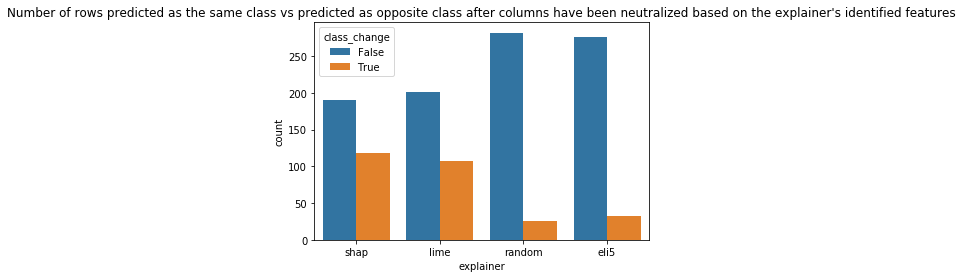

In [12]:
sns.countplot(x="explainer",data=res[(res['nsamples'] == 'auto') ], hue = 'class_change')
plt.title("Number of rows predicted as the same class vs predicted as opposite class after columns have been neutralized based on the explainer's identified features")

In [13]:
res.count()

original_probability    2464
new_probability         2464
confidence_diff         2464
original_class          2464
class_change            2464
no_features             2464
nsamples                2464
explainer               2464
time                    2464
reverse_order           2464
i0                      2464
i1                      2464
i2                      2464
i3                      2464
i4                      2464
i5                      2464
i6                      2464
i7                      2464
i8                      2420
i9                      2376
i10                     2376
dtype: int64

In [14]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'home_ownership', 'annual_inc', 'verification_status', 'dti',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'mort_acc',
       'pub_rec_bankruptcies', 'loan_repaid', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_educational',
       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_moving', 'purpose_other',
       'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'earliest_cr_year'],
      dtype='object')

Text(0.5, 1.0, 'Random - Contplot across all feature importances')

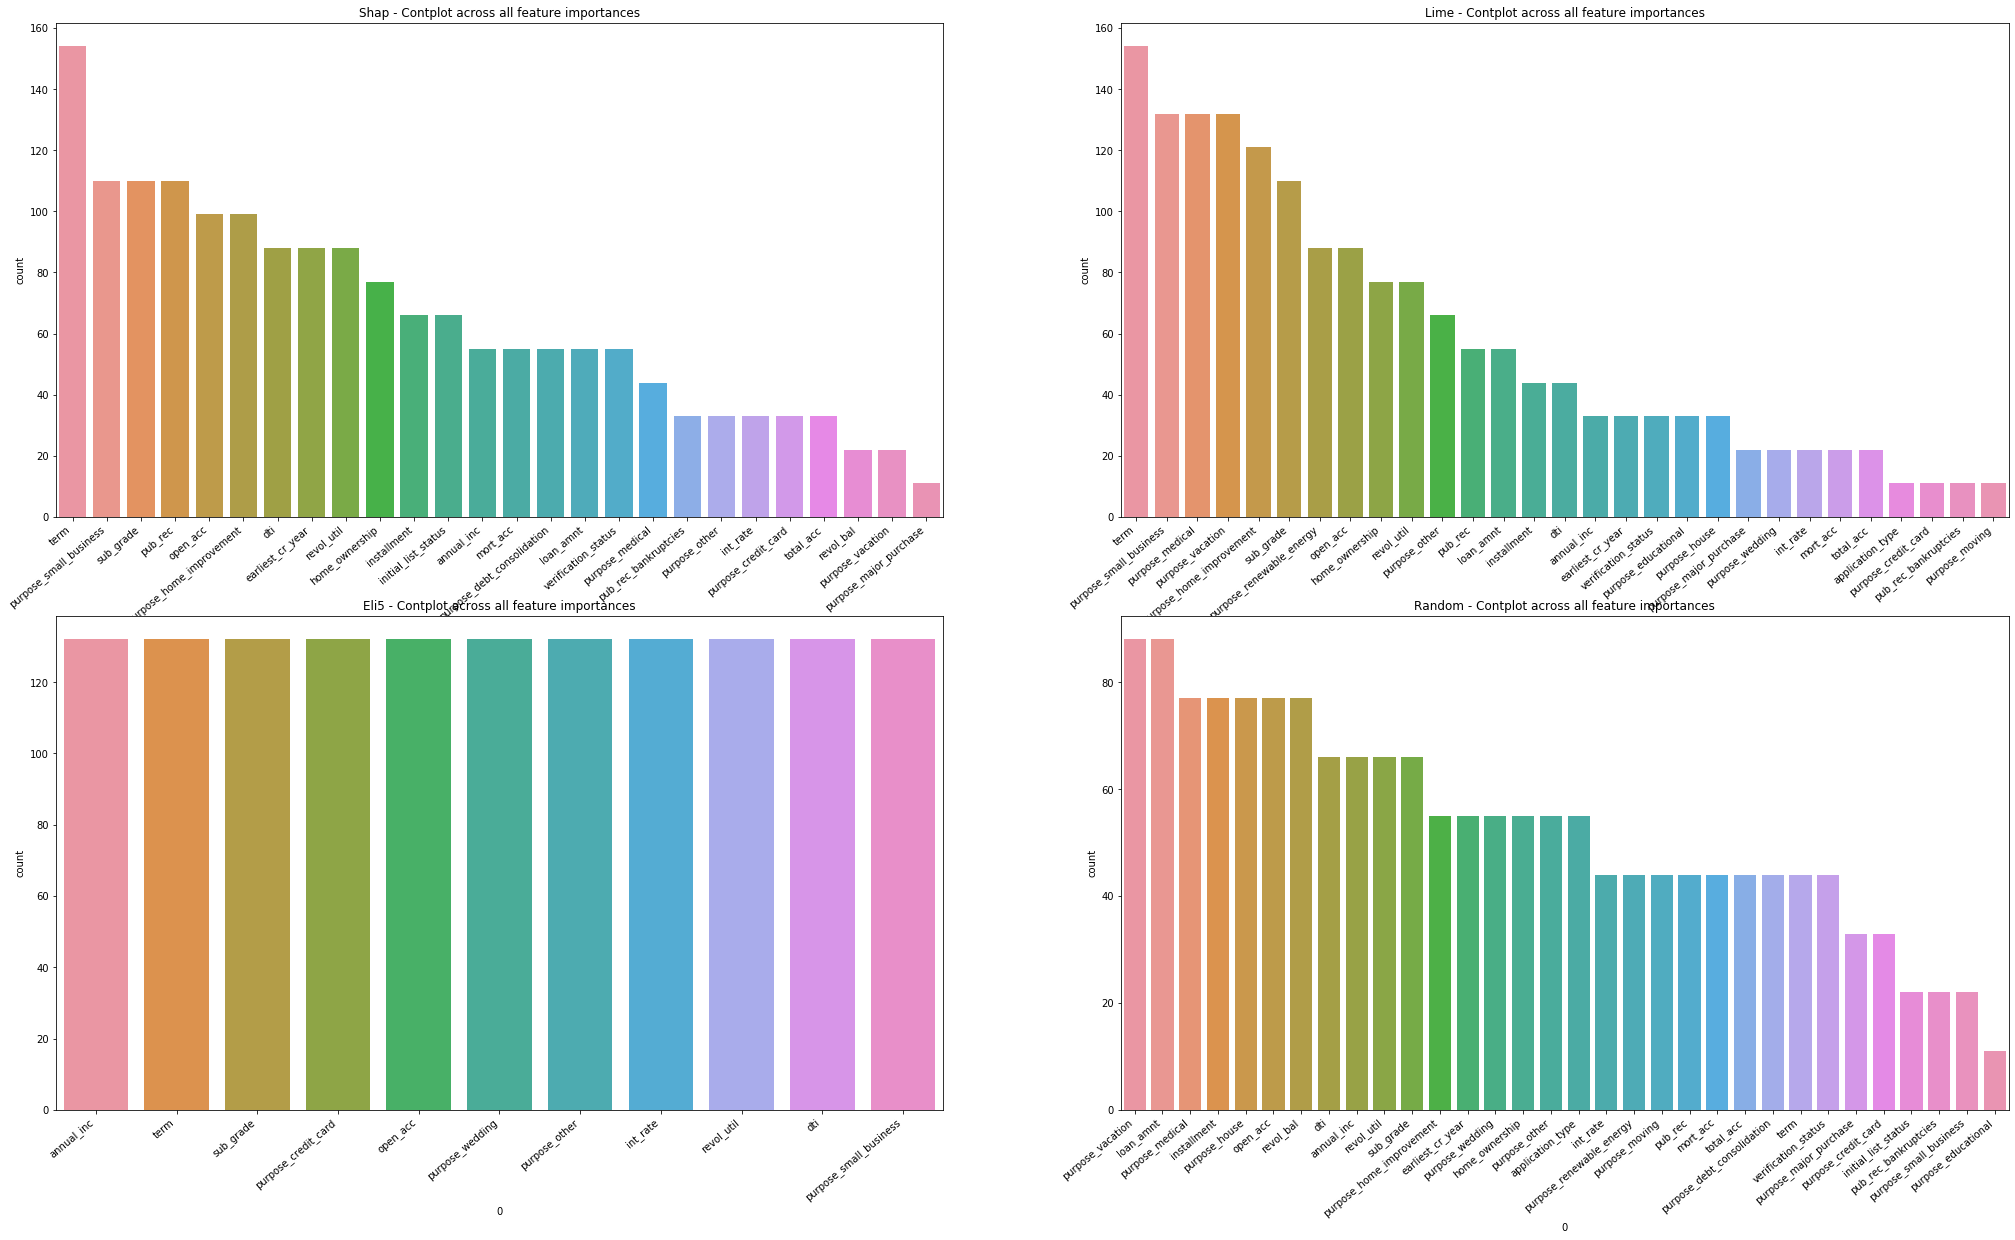

<Figure size 1800x288 with 0 Axes>

In [15]:
def get_countplot(explainer):
    columns = df.drop('loan_repaid', axis=1).columns
    result = res[(res['nsamples'] == 'auto') & (res['explainer'] == explainer) & (res["reverse_order"] == reverse_order)].drop(['original_probability',"new_probability", "confidence_diff", "original_class", "class_change","no_features","nsamples","explainer","time","reverse_order"],axis=1)
    result.columns = [''] * len(result.columns)
    result = result.dropna()
    flat_list = pd.DataFrame([columns[int(item)] for sublist in result.values.tolist() for item in sublist])
    return flat_list

f, ax = plt.subplots(nrows=2, ncols=2, figsize=(35, 20))
reverse_order = False
plt.figure(figsize=(25,4))

countplot_list = get_countplot("shap")
ax[0][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=40, ha="right")
ax[0][0].set_title("Shap - Contplot across all feature importances")

countplot_list = get_countplot("lime")
ax[0][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[0][1])
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=40, ha="right")
ax[0][1].set_title("Lime - Contplot across all feature importances")

countplot_list = get_countplot("eli5")
ax[1][0] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=40, ha="right")
ax[1][0].set_title("Eli5 - Contplot across all feature importances")

countplot_list = get_countplot("random")
ax[1][1] = sns.countplot(x =0, data =  countplot_list, order = countplot_list[0].value_counts().index, ax=ax[1][1])
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=40, ha="right")
ax[1][1].set_title("Random - Contplot across all feature importances")

In [16]:
result = res[(res['nsamples'] == 'auto') & (res['explainer'] == "shap") & (res["reverse_order"] == reverse_order)].drop(['original_probability',"new_probability", "confidence_diff", "original_class", "class_change","no_features","nsamples","explainer","time","reverse_order"],axis=1)
result.columns = [''] * len(result.columns)
result = result.dropna()
flat_list = pd.DataFrame([df.columns[int(item)] for sublist in result.values.tolist() for item in sublist])
# pd.DataFrame([df.columns[item] for item in flat_list])
flat_list

,0
0,int_rate
1,term
2,annual_inc
3,open_acc
4,initial_list_status
...,...
1689,dti
1690,installment
1691,purpose_educational
1692,pub_rec


Text(0.5, 1.0, 'Random')

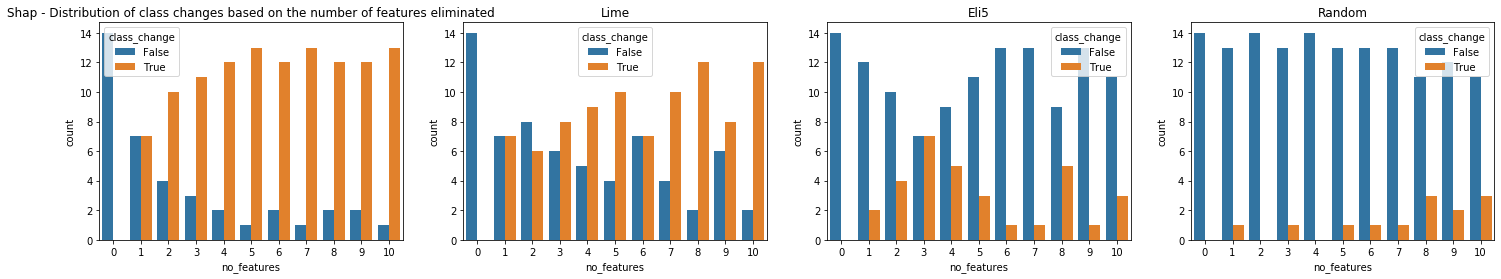

In [17]:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(25, 4))

data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == False)]

ax[0]=sns.countplot(x="no_features",data=data[data['explainer'] == 'shap'], hue = 'class_change', ax = ax[0])
ax[0].set_title("Shap - Distribution of class changes based on the number of features eliminated")

ax[1]=sns.countplot(x="no_features",data=data[data['explainer'] == 'lime'], hue = 'class_change', ax = ax[1])
ax[1].set_title("Lime")

ax[2]=sns.countplot(x="no_features",data=data[data['explainer'] == 'eli5'], hue = 'class_change', ax = ax[2])
ax[2].set_title("Eli5")

ax[3]=sns.countplot(x="no_features",data=data[data['explainer'] == 'random'], hue = 'class_change', ax = ax[3])
ax[3].set_title("Random")

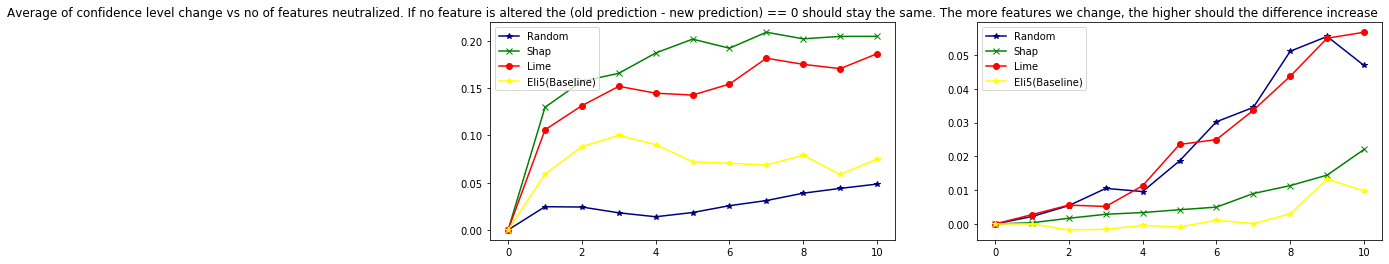

In [18]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, reverse_order ):
    data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == reverse_order)]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

reverse_order = False
no_of_features = list(range(0, len(get_data("random", False)) ))
ax[0].plot( no_of_features,  get_data("random", reverse_order), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", reverse_order) , color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", reverse_order) , color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", reverse_order) , color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
ax[0].set_title("Average of confidence level change vs no of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase")
ax[0].legend(loc='best')

reverse_order = True
no_of_features = list(range(0, len(get_data("random", reverse_order)) ))
ax[1].plot( no_of_features, get_data("random", reverse_order), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", reverse_order), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features,get_data("lime", reverse_order), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", reverse_order), color='yellow', marker='*', linestyle='-', label='Eli5(Baseline)')
# ax[1].set_title("Average of confidence level change vs no of features neutralized. If no feature is altered the (old prediction - new prediction) == 0 should stay the same. The more features we change, the higher should the difference increase")
ax[1].legend(loc='best')

In [19]:
res[(res['nsamples'] == 'auto') ].groupby("no_features")["confidence_diff"].mean() 

no_features
0    -2.128737e-08
1     4.060472e-02
2     5.154164e-02
3     5.664064e-02
4     5.753887e-02
5     6.012225e-02
6     6.303975e-02
7     7.102858e-02
8     7.559903e-02
9     7.707197e-02
10    8.132021e-02
Name: confidence_diff, dtype: float64

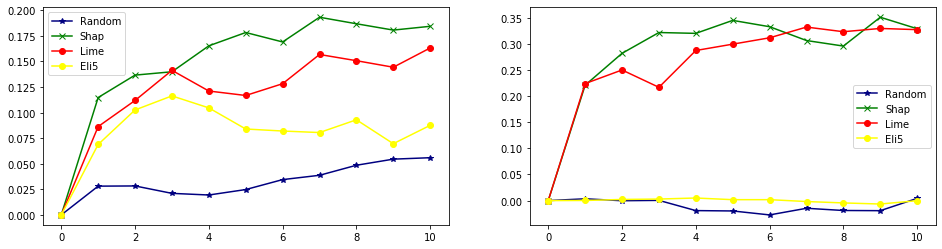

<Figure size 792x288 with 0 Axes>

<Figure size 792x288 with 0 Axes>

In [20]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, reverse_order ):
    data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == reverse_order)]
    return data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].mean()

original_class = 1
avg_random = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random') & (res['original_class'] == original_class) & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean() 
avg_shap = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'shap') & (res['original_class'] == original_class) & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()
avg_lime = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'lime') & (res['original_class'] == original_class)  & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()
avg_eli5 = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'eli5') & (res['original_class'] == original_class)  & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()

plt.figure(figsize=(11,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_random) ))
ax[0].plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, avg_eli5, color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].legend(loc='best')

original_class = 0
avg_random = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'random') & (res['original_class'] == original_class) & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean() 
avg_shap = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'shap') & (res['original_class'] == original_class) & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()
avg_lime = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'lime') & (res['original_class'] == original_class)  & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()
avg_eli5 = res[(res['nsamples'] == 'auto') & (res['explainer'] == 'eli5') & (res['original_class'] == original_class)  & (res["reverse_order"] == False)].groupby("no_features")["confidence_diff"].mean()

plt.figure(figsize=(11,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_random) ))
ax[1].plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, avg_eli5, color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].legend(loc='best')

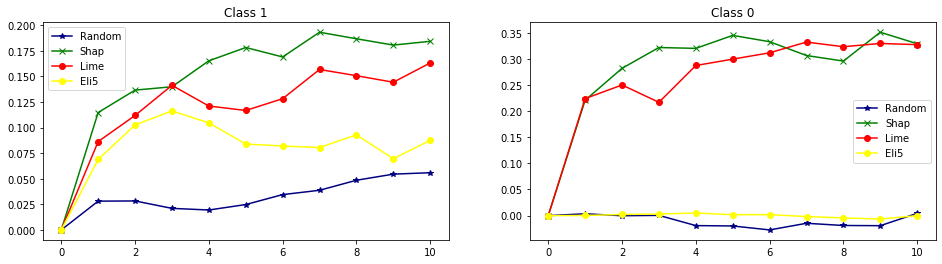

<Figure size 792x288 with 0 Axes>

<Figure size 792x288 with 0 Axes>

In [21]:
# Same as the graph above but the plot is class specific, in this case for class 1. For class 0, there are not enough datapoints to plot the graph
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

def get_data(explainer, original_class):
    default_data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == False)]
    return default_data[(default_data['explainer'] == explainer) & (default_data['original_class'] == original_class)].groupby("no_features")["confidence_diff"].mean()

original_class = 1
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(avg_random) ))
ax[0].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[0].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[0].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[0].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[0].set_title("Class {}".format(original_class))
ax[0].legend(loc='best')

original_class = 0
plt.figure(figsize=(11,4))
no_of_features = list(range(0, len(avg_random) ))
ax[1].plot( no_of_features, get_data("random", original_class), color='navy', marker='*', linestyle='-', label='Random')
ax[1].plot( no_of_features, get_data("shap", original_class), color='green', marker='x', linestyle='-', label='Shap')
ax[1].plot( no_of_features, get_data("lime", original_class), color='red', marker='o', linestyle='-', label='Lime')
ax[1].plot( no_of_features, get_data("eli5", original_class), color='yellow', marker='o', linestyle='-', label='Eli5')
ax[1].set_title("Class {}".format(original_class))
ax[1].legend(loc='best')

In [22]:
res[res["original_class"] == 0].head(5)

,original_probability,new_probability,confidence_diff,original_class,class_change,no_features,nsamples,explainer,time,reverse_order,...,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10
110,0.367168,0.367168,-5.960464e-08,0,False,0,100,shap,13.285344,False,...,1,9,29,0,31,12,19,17.0,10.0,3.0
111,0.367168,0.367168,-5.960464e-08,0,False,0,100,shap,1.227230,True,...,1,9,29,0,31,12,19,17.0,10.0,3.0
112,0.367168,0.533092,1.659240e-01,0,True,1,100,shap,1.459213,False,...,1,9,29,0,31,12,19,17.0,10.0,3.0
113,0.367168,0.367168,-5.960464e-08,0,False,1,100,shap,1.246459,True,...,1,9,29,0,31,12,19,17.0,10.0,3.0
114,0.367168,0.589103,2.219348e-01,0,True,2,100,shap,1.287072,False,...,1,9,29,0,31,12,19,17.0,10.0,3.0


Boolean Series key will be reindexed to match DataFrame index.


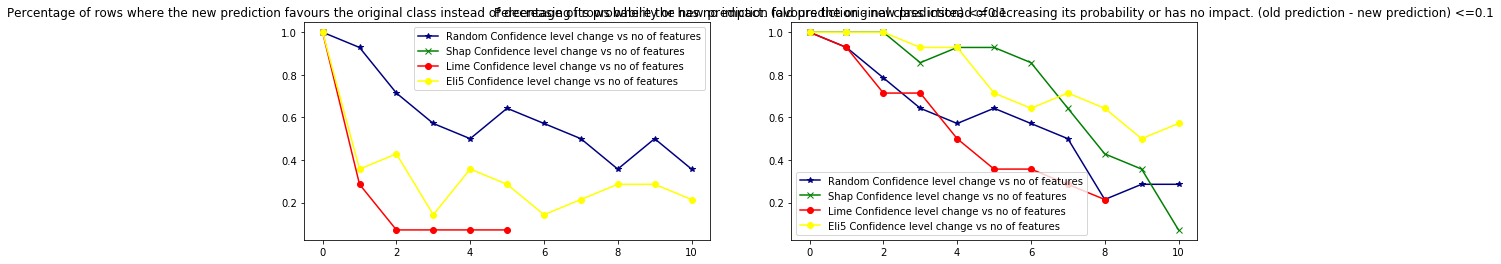

In [23]:
def get_data(explainer, reverse_order):
    data = res[(res['nsamples'] == 'auto') & (res["reverse_order"] == reverse_order)] 
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

reverse_order = False
no_of_features = list(range(0, len(get_data("random", reverse_order)) ))
ax[0].plot( no_of_features, get_data("random", reverse_order), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("shap", reverse_order), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("lime", reverse_order), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[0].plot( no_of_features, get_data("eli5", reverse_order), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[0].set_title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
ax[0].legend(loc='best')

reverse_order = True
no_of_features = list(range(0, len(get_data("random", reverse_order)) ))
ax[1].plot( no_of_features, get_data("random", reverse_order), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("shap", reverse_order), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("lime", reverse_order), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
ax[1].plot( no_of_features, get_data("eli5", reverse_order), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
ax[1].set_title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
ax[1].legend(loc='best')

Boolean Series key will be reindexed to match DataFrame index.


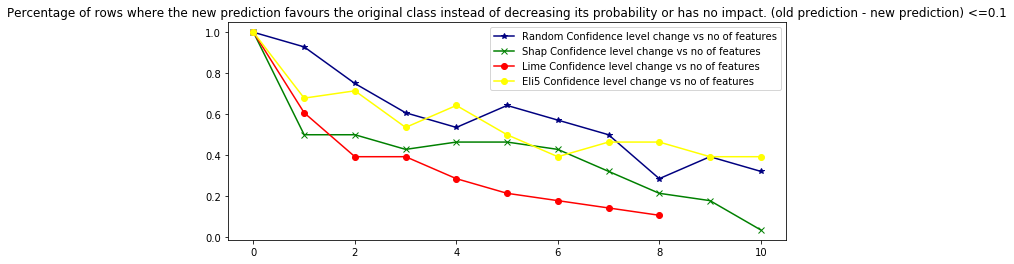

In [24]:
def get_data(explainer):
    data = res[res['nsamples'] == 'auto']
    data_count = data[(res['confidence_diff'] < 0.01)]
    return data_count[data_count['explainer'] == explainer].groupby("no_features")["confidence_diff"].count() / data[data['explainer'] == explainer].groupby("no_features")["confidence_diff"].count()

plt.figure(figsize=(10,4))
no_of_features = list(range(0, len(get_data("shap")) ))
plt.plot( no_of_features, get_data("random"), color='navy', marker='*', linestyle='-', label='Random Confidence level change vs no of features')
plt.plot( no_of_features, get_data("shap"), color='green', marker='x', linestyle='-', label='Shap Confidence level change vs no of features')
plt.plot( no_of_features, get_data("lime"), color='red', marker='o', linestyle='-', label='Lime Confidence level change vs no of features')
plt.plot( no_of_features, get_data("eli5"), color='yellow', marker='o', linestyle='-', label='Eli5 Confidence level change vs no of features')
plt.title("Percentage of rows where the new prediction favours the original class instead of decreasing its probability or has no impact. (old prediction - new prediction) <=0.1")
plt.legend(loc='best')

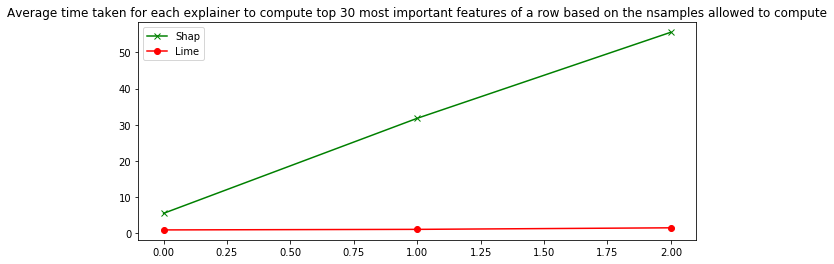

In [25]:

# avg_random = res[(res["no_features"]==0) & (res['explainer'] == 'random')].groupby("nsamples")["time"].mean() 
avg_shap = res[(res["no_features"]==0) & (res['explainer'] == 'shap')].groupby("nsamples")["time"].mean()
avg_lime = res[(res["no_features"]==0) & (res['explainer'] == 'lime')].groupby("nsamples")["time"].mean()

plt.figure(figsize=(10,4))
# plt.set_title('Training & Validation Loss')
no_of_features = list(range(0, len(avg_shap)))
# plt.plot( no_of_features, avg_random, color='navy', marker='*', linestyle='-', label='Random')
plt.plot( no_of_features, avg_shap, color='green', marker='x', linestyle='-', label='Shap')
plt.plot( no_of_features, avg_lime, color='red', marker='o', linestyle='-', label='Lime')
plt.title("Average time taken for each explainer to compute top 30 most important features of a row based on the nsamples allowed to compute")
plt.legend(loc='best')

In [26]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance

def base_model():       
    return model
# X_train_unscaled, X_test_unscaled, y_train, y_test
# train_x, val_x, train_y, val_y
my_model = KerasRegressor(build_fn=base_model)    
my_model.fit(X_test, y_test)

# perm = PermutationImportance(my_model).fit(X_test[0:1000],y_test[0:1000])
eli5.show_weights(perm, feature_names = list(df.drop('loan_repaid', axis=1).columns))

Using TensorFlow backend.


Train on 79044 samples
79044/79044 [==============================] - 10s 120us/sample - loss: 0.4653 - accuracy: 0.8018 - f1: 0.8877

NameError: name 'perm' is not defined

In [ ]:
# eli5.show_prediction(model, X_test[row_number].reshape(1, X_test.shape[1]))

In [ ]:
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html -- types of plots available for shap
import shap
def predict_fn(x):
    preds = model.predict(x).reshape(-1, 1)
    p0 = 1 - preds
    return np.hstack((p0, preds))
row_number=1
explainer_shap = shap.KernelExplainer(predict_fn, X_train[0:1000])
shap_values = explainer_shap.shap_values(X_test[row_number].reshape(1, X_test.shape[1]), nsamples="auto", l1_reg="num_features(30)")

shap.decision_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [ ]:
shap.initjs()
shap.force_plot(explainer_shap.expected_value[0], shap_values[0][0, :], X_test[row_number], feature_names=list(df.drop('loan_repaid', axis=1).columns), link="logit")

In [ ]:
explainer_lime = lime_tabular.LimeTabularExplainer(X_train, training_labels=['paid', 'unpaid'])
exp = explainer_lime.explain_instance(X_test[row_number], predict_fn, num_features=30, top_labels=30)  
exp.show_in_notebook(show_table=True, show_all=False)

In [ ]:
%reload_ext tensorboard

In [ ]:
!kill -9 3788

In [ ]:
# %tensorboard --logdir "logs\\hparam_tuning\\2020-07-04-2313" --host localhost --port 8080

In [ ]:
pwd

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir "ray_results\\create_model_tune_cofig" 

In [30]:
import os
path="/home/dan393/ray_results_f/create_model_tune_cofig"
os.chdir(path)
for file in os.listdir():
    if os.path.isdir(file):
        split_words = file.split("_")
        os.rename(file, "create_model_tune_cofig_{}_{}".format(split_words[4], split_words[len(split_words)-1]))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/dan393/ray_results_f/create_model_tune_cofig'